In [159]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
import seaborn as sns
from datetime import datetime,date
%matplotlib inline

In [64]:
fb_data = pd.read_csv('/Users/eve/Desktop/u1l5/facebook-fact-check.csv')

In [4]:
list(fb_data)

['account_id',
 'post_id',
 'Category',
 'Page',
 'Post URL',
 'Date Published',
 'Post Type',
 'Rating',
 'Debate',
 'share_count',
 'reaction_count',
 'comment_count']

In [65]:
fb_data['Date Published'] = fb_data['Date Published'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
fb_data ['Date Published'] = fb_data['Date Published'].map(lambda x:x.date())

In [55]:
print(fb_data[0:5])

        account_id           post_id    Category               Page  \
0  184096565021911  1035057923259100  mainstream  ABC News Politics   
1  184096565021911  1035269309904628  mainstream  ABC News Politics   
2  184096565021911  1035305953234297  mainstream  ABC News Politics   
3  184096565021911  1035322636565962  mainstream  ABC News Politics   
4  184096565021911  1035352946562931  mainstream  ABC News Politics   

                                            Post URL Date Published Post Type  \
0  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19     video   
1  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19      link   
2  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19      link   
3  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19      link   
4  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19     video   

               Rating Debate  share_count  reaction_count  comment_count  
0  no factu

In [8]:
print(fb_data['Rating'].unique())

['no factual content' 'mostly true' 'mixture of true and false'
 'mostly false']


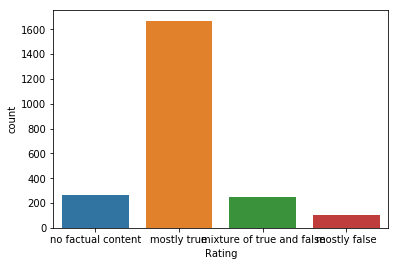

In [9]:
sns.countplot(fb_data['Rating'])

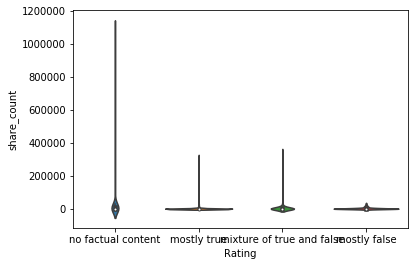

In [35]:
sns.violinplot(x=fb_data['Rating'], y=fb_data['share_count']);

In [138]:
summary_frame = pd.DataFrame(columns=['rating','share_count','reaction_count','comment_count'])
    
for rating in truth_ratings:
    data_slice = fb_data[fb_data.Rating==rating][['Date Published','share_count','reaction_count','comment_count']].groupby('Date Published').sum()
    data_slice['x_loc'] = (np.arange(1,8))
    data_slice['rating'] = [rating] * 7
    summary_frame = pd.concat([summary_frame, data_slice])

summary_frame.reset_index(level=0, inplace=True)
summary_frame.rename(columns = {'index':'date'}, inplace = True)

print(summary_frame)

          date  comment_count                     rating  reaction_count  \
0   2016-09-19        16646.0         no factual content        158997.0   
1   2016-09-20        23370.0         no factual content        490797.0   
2   2016-09-21       184461.0         no factual content        868600.0   
3   2016-09-22        13382.0         no factual content        352950.0   
4   2016-09-23        35372.0         no factual content        680877.0   
5   2016-09-26        49676.0         no factual content        890368.0   
6   2016-09-27        64979.0         no factual content       1710228.0   
7   2016-09-19        96985.0                mostly true        512621.0   
8   2016-09-20        69275.0                mostly true        779258.0   
9   2016-09-21        72280.0                mostly true        519732.0   
10  2016-09-22        53286.0                mostly true        404222.0   
11  2016-09-23        58515.0                mostly true        469006.0   
12  2016-09-

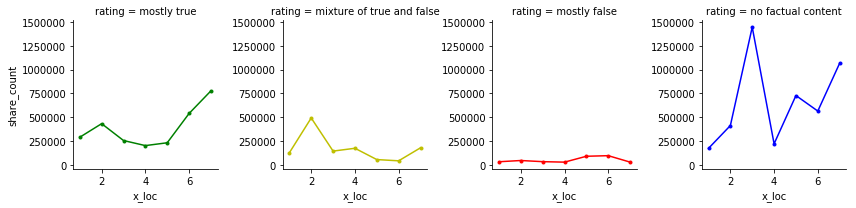

In [161]:
rating_order = ['mostly true','mixture of true and false','mostly false','no factual content']

color_order = ['b','g','y','r']

g = sns.FacetGrid(summary_frame,
                  palette=sns.color_palette(color_order), 
                  col="rating", 
                  hue="rating", 
                  col_order=rating_order,
                 sharey=True)
g.map(plt.plot,"x_loc","share_count", marker=".")
plt.show()

In [ ]:
sns.tsplot

In [49]:
print(fb_date)

                       account_id              post_id  share_count  \
Date Published                                                        
2016-09-19      58467724053267432   935143432421774080     628756.0   
2016-09-20      58851548986017824  1032716659278166016    1387877.0   
2016-09-21      55684925383830328  1036569147890368256    1883505.0   
2016-09-22      55321883235410440   914126677777476224     631871.0   
2016-09-23      56165274346761648   933085487065244800    1110691.0   
2016-09-26      73073981686243936  1467444860098863872    1248238.0   
2016-09-27      68509391737974136  1210569690537403648    2056194.0   

                reaction_count  comment_count  
Date Published                                 
2016-09-19            870990.0       138629.0  
2016-09-20           1903859.0       167517.0  
2016-09-21           1552459.0       275505.0  
2016-09-22           1050564.0       107517.0  
2016-09-23           1387186.0       117536.0  
2016-09-26           230